#  ATLAS/ICESat-2 Monthly Gridded Sea Ice Freeboard
We use the ICESat-2 ATL10 sea ice freeboard product (currently at Release 004, rel004), which is disseminated through the NSIDC (https://nsidc.org/data/atl10). Sea ice freeboard represents the vertical extension of sea ice (including its overlying snow cover in this case) above a local sea level. By combining measurements of freebaord with ancillary information regarding snow loading, sea ice density and the assumption of hydrostatic equilibirum, measurements of freeboard can be converted to estimates of sea ice thickness (see http://www.alekpetty.com/papers/petty2020). ATL10 is the end result of a series of algorithms that convert the primary ICESat-2 geolocated photon product ATL03 (https://nsidc.org/data/atl03) to sea ice height and type - ATL07 (https://nsidc.org/data/atl07) and then polar sea surface height and freeboard - ATL10 (https://nsidc.org/data/atl10). The thickness data presented here are derived from the along-track freeboard product (ATL10) and snow loading from NASA's Eulerian Snow On Sea Ice Model (NESOSIM). The data are gridded to the same NSIDC Polar Stereographic grid as the official gridded freeboard product ATL20. 

# 1) Read data

## Set desired date range 
Our analysis looks at winter data, so we'll only load data for the Northern Hemisphere's winter season (Nov-Apr)

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import utils # See utils module in github repository
import warnings # Remove warnings to improve display
warnings.filterwarnings('ignore')

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
from textwrap import wrap
import matplotlib as mpl
import matplotlib.pyplot as plt

GeoAxes._pcolormesh_patched = Axes.pcolormesh
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 100

In [2]:
start_year = "2018"
end_year = "2020"
winter_months = utils.getWinterDateRange(start_year, end_year)
print(winter_months)

DatetimeIndex(['2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', freq=None)


## Read in ICESat-2 data 
If the data doesn't already exist in the user's local drive, the function read_is2_data will download the files from the google storage bucket.

In [3]:
is2_ds = utils.read_is2_data() # Read in data
is2_ds = is2_ds.sel(time = winter_months) # Get winter months
print(is2_ds)

<xarray.Dataset>
Dimensions:            (time: 12, x: 304, y: 448)
Coordinates:
    longitude          (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    latitude           (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    xgrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
    ygrid              (y, x) float32 dask.array<chunksize=(448, 304), meta=np.ndarray>
  * time               (time) datetime64[ns] 2018-11-01 ... 2020-04-01
Dimensions without coordinates: x, y
Data variables:
    projection         (time) int32 -2147483647 -2147483647 ... -2147483647
    ice_thickness      (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness_unc  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    num_segments       (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    mean_day_of_month  (time, y, x) float32 dask.array<chunksize=(1, 448, 304

## Set interpolation preferences  
The dataset included uninterpolated data, or we can interpolate the data using a simple nearest neighbor interpolation function. Because ICESat-2 doesn't provide full monthly coverage, interpolating fills missing grid cells with a best guess based on surrounding data. This helps avoid sampling biases when performing time series analyses, with the cavaet that this interpolation method is subjective. <br><br>
In order to definte the interpolation bounds (so that we don't try and interpolate over land, or other areas where there wouldn't be sea ice!), we use the [NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://nsidc.org/data/g02202) dataset to infer the location of the sea ice. By setting interpolation=True, the code calls an interpolation function that is defined in the utils module.

In [4]:
interpolate = True 

if (interpolate == True): 
    cdr_da = utils.read_book_data()["seaice_conc_monthly_cdr"] # Get CDR data
    cdr_da = cdr_da.sel(time = winter_months) # Get winter months
    is2_ds = utils.is2_interp2d(is2_ds, cdr_da, method='nearest', interp_var='all')

# 2) Plot mean winter ice thickness
Using the cartopy mapping package for python, we overlay mean ice thickness for each winter season on a basemap of the Arctic.

In [5]:
def plotArcticOneMonth(da, minval=None, maxval=None, title=None, cmap='viridis', show_mean=True): 
    """Plots map of the arctic on North Pole Stereo projection with one month of data overlayed, along with the sea ice edge for each month.
    Cartopy has a bug and cannot produce a contour plot on a rotated grid. Here we use a workaround from stackexchange: https://stackoverflow.com/questions/55062406/cartopy-fails-to-correctly-contour-data-on-rotated-grid
   
    Args:
        da (xr DataArray): data to plot
        minval, maxval (int, optional): minimum and maximum values for the data variable (default to xarray default)
        cmap (str, optional): color map (default to viridis)
        title (str, optional): title of subplots (default to empty string)
        show_mean (bool, optional): add mean value to plot (default to True)
        
    Returns:
        Figure displayed in notebook 
    
    """
    # Plot the data
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
    da.plot(x='longitude', y='latitude', vmin=minval, vmax=maxval, extend='both', 
            ax=ax, add_colorbar=True, transform=ccrs.PlateCarree(), zorder=2, cmap=cmap, 
            cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.75, 'pad': 0.025})
    
    # Add features to the map
    ax.coastlines(linewidth=0.15, color = 'black', zorder = 10) # Coastlines
    ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5)    # Land
    ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5)  # Lakes
    ax.gridlines(draw_labels=False, linewidth=0.25, color='gray', alpha=0.7, linestyle='--', zorder=6) # Gridlines
    ax.set_extent([-179, 179, 50, 90], crs=ccrs.PlateCarree()) # Set extent to zoom in on Arctic
    
    if title is not None: # Set title
        ax.set_title("\n".join(wrap(title, 40)), fontsize=13, y=1, fontweight='medium')
    
    if show_mean: # Compute and show mean value 
        mean_val = round(da.mean().values.item(),2)
        ax.text(x = 0.68, y = 0.97, s = "mean val: " + str(mean_val), zorder=20, horizontalalignment='left', verticalalignment='top', fontsize=10, transform=ax.transAxes, bbox={'facecolor':'white','edgecolor':'lightgrey','boxstyle':'round'})
    
    plt.show()

In [6]:
thickness = is2_ds["ice_thickness"]

## Winter 2018-19

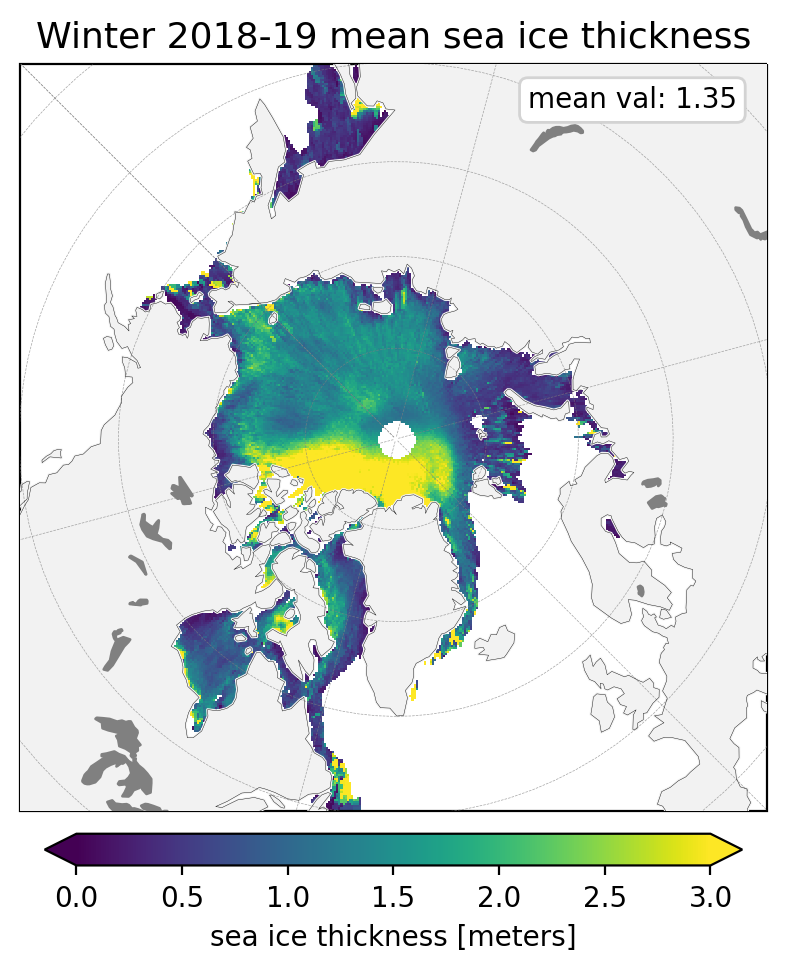

In [7]:
# Compute mean thickness for winter 1 (Nov 2018 - Apr 2019)
thickness_av_winter1 = thickness.sel(time=slice("Nov 2018", "Apr 2019")).mean(dim = ["time"])
thickness_av_winter1 = thickness_av_winter1.assign_attrs(thickness.attrs)

# Plot
plotArcticOneMonth(thickness_av_winter1, minval=0, maxval=3, title="Winter 2018-19 mean sea ice thickness")

## Winter 2019-20

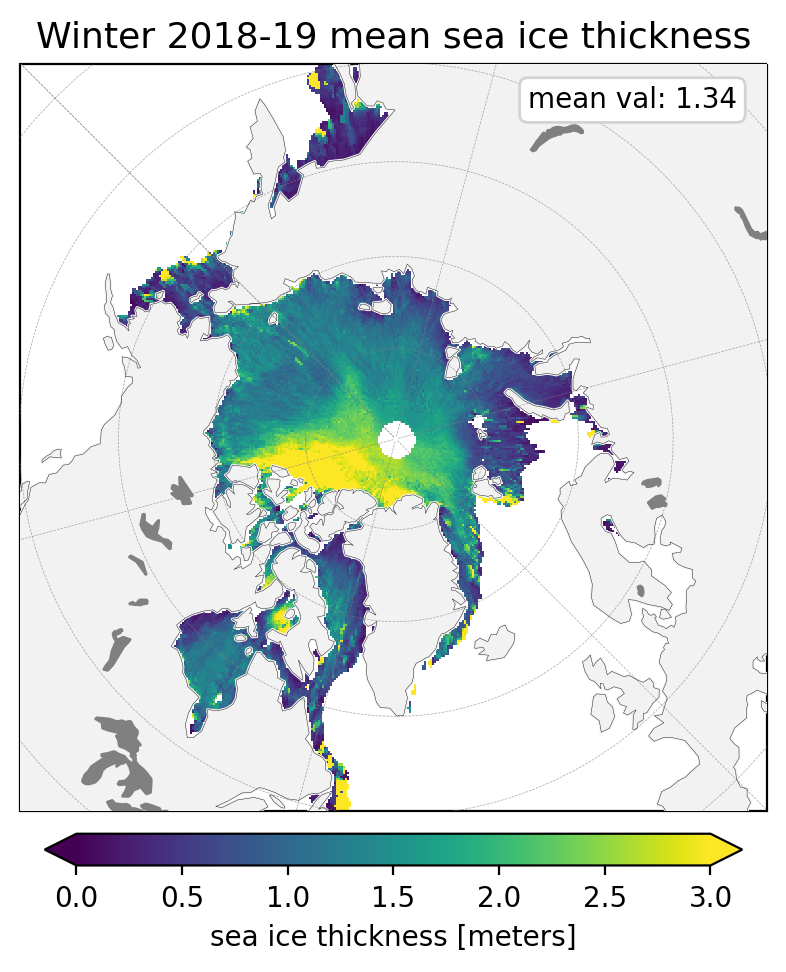

In [8]:
# Compute mean thickness for winter 2 (Nov 2019 - Apr 2020)
thickness_av_winter2 = thickness.sel(time=slice("Nov 2019", "Apr 2020")).mean(dim = ["time"])
thickness_av_winter2 = thickness_av_winter2.assign_attrs(thickness.attrs)

# Plot
plotArcticOneMonth(thickness_av_winter2, minval=0, maxval=3, title="Winter 2018-19 mean sea ice thickness")